In [5]:
from __future__ import division
from __future__ import print_function
import matplotlib
% matplotlib inline
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy.linalg as alg
import scipy as spy
import networkx as nx

import time
from itertools import *
import sys
import numpy.linalg as LA
import pickle
# set hyperparameter Lambda and Rho
Lambda = 0.1
Rho = 1

import random
import numpy as np
import numpy.linalg as LA
import scipy as spy
import time
from itertools import *
import sys
import cvxpy as cvx
from random import randint
import numpy as np
import random
from scipy.sparse import csc_matrix
from scipy import sparse as sp
import networkx as nx
from multiprocessing import Pool
import multiprocessing
from scipy.special import expit
from sklearn import linear_model, datasets

In [58]:
class ADMM:
    '''
    ADMM for graph regularization Python class
    input: 
        X: feature matrix, N*d matrix
        y: N*1 label vector, where y_i = 0, if node i is in test indices
        G: graph with N nodes as a nested dictionary
        Lambda: hyperparameter to control graph regularization
        Rho: hyperparameter to control ADMM stepsize
        train_mask: N*1 boolean vector
        test_mask: N*1 boolean vector
        y_true: N*1 label vector
        Threshold:hyperparameter as the stopping criteria of ADMM algorithm
        paramters, features, labels, and graph structure
    output: 
        W: estimated W, d*1 vector
        b: estimated b, N*1 vector
        losses: losses per iteration
    '''
    def __init__(self, X, y, G, nodes, edgeNbr, Lambda, Rho, train_mask, test_mask, y_true, Threshold, initialW, initialb):
        self.X = X
        self.y = y
        self.Threshold = Threshold
        self.y_true = y_true
        self.train_mask = train_mask
        self.test_mask = test_mask
        self.dim = X.shape[1]
        self.Lambda = Lambda
        self.Rho = Rho
        self.graph = G
        self.nodes = nodes

        row=[]
        col=[]
        for i, js in self.graph.items():
            for j in js:
                row.append(i)
                col.append(j)
                
        initialZ=np.random.rand(len(row))
        initialU=np.random.rand(len(row))
        self.Z = collections.defaultdict(dict)
        self.U = collections.defaultdict(dict)
        k=0
        for i, js in self.graph.items():
            for j in js:
                self.Z[i][j]=initialZ[k]
                self.U[i][j]=initialU[k]
                k+=1

        # set the initial value of W and b with the logistics regression result
        self.W = initialW.reshape(X.shape[1])
        self.b = np.ones(X.shape[0])*initialb

    def dumpWb(self, filename):
        dict = {"W": self.W, "b": self.b}
        with open(filename, "wb") as f:
            pickle.dump( dict, f)
        
    def deriv_b(self, b, C1, C2, C3, eC1):
        if (eC1 == float('inf')):
            return C2 + C3 *b
    
        return 1/(1+ eC1* math.exp(-1.0*b)) + C2 + C3*b

    def deriv_b_negy(self, b, C1, C2, C3, eC1):
        if (eC1 == float('inf')):
            return C2 + C3 *b
        
        return -1.0/(1+ eC1* math.exp(b)) + C2 + C3*b
    
    def update_b(self):
        '''
        update the value of b, check line 4 of the ADMM algorithm for the math
        cvxpy is conducted independently for each node
        '''
        B = []
        num_nodes = len(self.nodes)
        kk=0
        for i in self.nodes:
            #if kk%1000000==0:
            #    self.logger.info('update_b: {0} %{1:4.2f}'.format(i, kk *1.0 /num_nodes *100 ))
            #    kk+=1
                
            sumdiffZU = 0
            neighborCnt = 0
            for Id in self.graph[i]:
                sumdiffZU += (self.Z[i][Id]-self.U[i][Id])
                neighborCnt += 1

            if (neighborCnt == 0):
                 raise ValueError('{0} has no neighbor'.format(i))

            b1 = sumdiffZU /neighborCnt

            #in case of missing value, we have analytical solution for b
            if (self.y[i]==0):
                self.b[i]= b1
                continue

            tol = 1e-5

            #the optimial value is within the interval [b1, b2]
            if (self.y[i]==1):
                b2 = b1 + 1/self.Rho/neighborCnt
                #bisection method to find a better b
                C1 = -1.0 * self.X[i].dot(self.W) #C1 = -1.0 * self.X[i].dot(self.g[i,:])
                C2 = -1-self.Rho * sumdiffZU
                C3 = self.Rho * neighborCnt
                eC1 = 0
                try:
                    eC1 = math.exp(C1)
                except OverflowError:
                    eC1 = float('inf')
                while(b2-b1 > tol):
                    Db1 = self.deriv_b(b1, C1, C2, C3, eC1)
                    Db2 = self.deriv_b(b2, C1, C2, C3, eC1)
                    if (math.fabs(Db1)<tol):
                        b2 = b1
                        break;

                    if (math.fabs(Db2)<tol):
                        b1 = b2
                        break;
                    
                    if (not(Db1<=tol and Db2>=-1.0*tol)):
                        raise ValueError('Db1 and Db2 has same sign which is impossible! Db1={0}, Db2={1}, b1={2}, b2={3}'.format(Db1, Db2, b1, b2))
                    
                    b3 = (b1 + b2)/2
                    Db3 = self.deriv_b(b3, C1, C2, C3, eC1)
                    if (Db3 >=0):
                        b2=b3
                    else:
                        b1=b3
                    
                self.b[i] = (b1 + b2)/2
                continue

            if (self.y[i]==-1):
                b2 = b1
                b1 = b2 - 1/self.Rho/neighborCnt
                C1 = self.X[i].dot(self.W) #C1 = self.X[i].dot(self.g[i,:])
                C2 = 1-self.Rho * sumdiffZU
                C3 = self.Rho * neighborCnt
                eC1 = 0
                try:
                    eC1 = math.exp(C1)
                except OverflowError:
                    eC1 = float('inf')
                    
                while(b2-b1 > tol):
                    Db1 = self.deriv_b_negy(b1, C1, C2, C3, eC1)
                    Db2 = self.deriv_b_negy(b2, C1, C2, C3, eC1)
                    if (math.fabs(Db1)<tol):
                        b2 = b1
                        break;

                    if (math.fabs(Db2)<tol):
                        b1 = b2
                        break;
                    
                    if (not(Db1<=tol and Db2>=-1.0*tol)):
                        raise ValueError('Db1 and Db2 has same sign which is impossible! Db1={0}, Db2={1}, b1={2}, b2={3}, C1={4}, C2={5}, C3={6}'.format(
                            Db1, Db2, b1, b2, C1, C2, C3))
                    
                    b3 = (b1 + b2)/2
                    Db3 = self.deriv_b_negy(b3, C1, C2, C3, eC1)
                    if (Db3 >=0):
                        b2=b3
                    else:
                        b1=b3
                        
                    
                self.b[i] = (b1 + b2)/2
                continue
            
            raise ValueError('impossible value for y={0}'.format(self.y[i]))
        
    def update_Z(self):
        '''
        update the value of Z, check line 6 of the ADMM algorithm for the math
        rho is lambda times rho2
        f is L_{rho}(W_t^{k+1}, b_t^{k+1}, g^{k+1}, (z_{ij}, z_{ji}, z_{(ij)^c}^k, u^k, h^k; t)
        see page 5 of https://arxiv.org/pdf/1703.07520.pdf Social discrete choice model
        '''
        for k in self.graph:
            for j in self.graph[k]:
                A = self.b[j] + self.U[j][k]
                B = self.b[k] + self.U[k][j]
                self.Z[k][j] = (2*self.Lambda*A + (2*self.Lambda+self.Rho)*B)/(self.Lambda*4+self.Rho)

    def update_U(self):
        '''
        update the value of U, check line 7 of the ADMM algorithm for the math
        '''
        for i in self.graph:
            for Id in self.graph[i]:
                self.U[i][Id] = self.U[i][Id] + self.b[i] - self.Z[i][Id]

                
    '''
    using a simple gradient descent algorithm to update W
    https://www.cs.cmu.edu/~ggordon/10725-F12/slides/05-gd-revisited.pdf
    learning rate is chosen using Backtracking linear search. see page 10 of the slides above
    '''
    def update_W(self, iteration):
        featureCnt = len(self.W)
        maxiter = 2
        oldloss = self.cal_LL()
        newloss = oldloss
        for k in range(maxiter):
            learningrate = 0.00001
            oldloss = newloss
            print('update W iteration {0}.{1}'.format(iteration, k))
            gradient = np.zeros(featureCnt)
            for i in self.graph:
                if (self.y[i]==0):
                    continue
                C1 = -1.0 * self.y[i]* (self.X[i].dot(self.W) + self.b[i])
                eC1 = 0
                multiplier = 0
                try:
                    eC1 = math.exp(C1)
                except OverflowError:
                    eC1 = float('inf')
                if (eC1==float('inf')):
                    multiplier =  -1.0*self.y[i]
                else:
                    multiplier = (1 - 1.0/(1.0+eC1)) * (-1.0)*self.y[i]
                    
                gradient = np.add(gradient, multiplier * self.X[i])

            gradientNorm = np.linalg.norm(gradient)

            if (gradientNorm == float('inf')):
                raise ValueError('norm of gradient is infinity') #should never happen

            gradientNorm2 = gradientNorm * gradientNorm
            
            oldW = np.copy(self.W)
            kk=0
            newloss = 0
            tol = 1e-5
            while (True):
                np.copyto(self.W, oldW)
                self.W -= learningrate * gradient
                anticipateddecrease = learningrate * gradientNorm2 /2.0
                print('anticipate the loss to decrease from {0} by {1}'.format(oldloss, anticipateddecrease))
            
                targetloss = oldloss - anticipateddecrease
                
                try:
                    newloss = self.cal_LL()
                except OverflowError:
                    learningrate = learningrate / 2
                    kk+=1
                    print('get infinite loss, reduce learning rate to {0}, kk={1}'.format(learningrate, kk))
                    continue
                
                if (newloss <= targetloss + tol):
                    break;
                
                learningrate  = learningrate / 2
                
                kk+=1
                print('loss is not decreasing below anticipated value, reduce learning rate to {0}, kk={1}'.format(learningrate, kk))
                if(kk>1000):
                    raise ValueError('cannot find a good learning rate to get finite loss.learningrate={0}'.format(learningrate))
                
            print('learning rate: {0}'.format(learningrate))
            print('max in gradient is :{0}'.format(np.max(np.abs(gradient))))
            print('oldloss:' + str(oldloss) + ',newloss:' + str(newloss))
            if(math.fabs(newloss-oldloss) < 0.00001 * oldloss):
                return newloss
        return newloss
            
    def optimize_b(self, iterations, old_loss, verbose=False):
        kk = 0
        maxiter = 5
        while (True):
            start2 = time.time()
            self.update_b()
            end2 = time.time()
            if(verbose):
                print('finished b {0} seconds at iteration {1}'.format(end2-start2, iterations))
            start2 = time.time()
            self.update_Z()
            end2 = time.time()
            if(verbose):
                print('finished Z {0} seconds at iteration {1}'.format(end2-start2, iterations))
            start2 = time.time()
            self.update_U()
            end2 = time.time()
            if(verbose):
                print('finished U {0} seconds at iteration {1}'.format(end2-start2, iterations))
            loss = self.cal_LL()
            print('loss is {0}, old loss is {1} at iteration {2}.{3}'.format(loss, old_loss, iterations, kk))
            kk+=1
            if(np.absolute(old_loss-loss)<=self.Threshold):
                return loss
            if (kk > maxiter):
                return loss
                        
    def runADMM_Grid(self):
        '''
        runADMM Grid iterations
        The stopping criteria is when the difference of the value of the objective function in current iteration
        and the value of the objective function in the previous iteration is smaller than the Threshold
        '''
        resultdump = 'result.dump'
#         self.dumpWb(resultdump + ".initial")
        self.losses = []
        self.times = []
        loss = self.cal_LL()
        self.losses.append(loss)
        print('iteration = 0')
        print('objective = {0}'.format(loss))
        old_loss = loss
        loss = float('inf')
        iterations = 0
        import time
        start = time.time()
        while(True):
            loss = self.optimize_b(iterations, old_loss)
            
            start2 = time.time()
            loss = self.update_W(iterations)
            end2 = time.time()
            print('finished w {0} seconds at iteration {1}'.format(end2-start2, iterations))
            print('loss is {0}, old loss is {1} at iteration {2}'.format(loss, old_loss, iterations))
            loss = self.cal_LL()
            self.losses.append(loss)
            if(np.absolute(old_loss- loss) <=  self.Threshold):
                break
            old_loss = loss
            iterations += 1
#             if (iterations % 2 == 0):
#                 self.dumpWb(resultdump + "." + str(iterations))

        print('total iterations = ' + str(iterations))
        end = time.time()
        print('total time = {0}'.format(end-start))
#         self.dumpWb(resultdump + ".final" )

    def cal_LL(self):
        '''
        function to calculate the value of loss function
        '''
        W = np.array(self.W).flatten()
        b = np.array(self.b).flatten()
        loss = 0
        for i in self.nodes:
            r = np.log(1 + np.exp(-self.y[i]*(np.dot(self.X[i], W) + b[i])))
            if(r == float('inf')):
                raise OverflowError('loss is infinity')
            loss += r
        
        for i, js in self.graph.items():
            for j in js:
                loss +=  self.Lambda*(self.b[i]-self.b[j])**2
        return loss

In [29]:
!ls graph1/

G.p          Y.p          test_mask.p  y_test.p
X.p          Y_true.p     train_mask.p y_train.p


In [31]:
G3 = pickle.load(open("graph1/G.p"))
for u,v in G3.edges():
    G3[u][v]['pos_edge_prob'] = 1
for i in range(G3.number_of_nodes()):
    G3.node[i]['pos_node_prob'] = 1
# get all the nodes of the graph
nodes = G3.nodes()
# get some statistics about the graph
print('number of nodes',G3.number_of_nodes())
print('number of edges',G3.number_of_edges())

y_train = pickle.load( open( "graph1/y_train.p", "rb" ) )
y_true = pickle.load( open( "graph1/Y_true.p", "rb" ) )
y_test = pickle.load( open( "graph1/y_test.p", "rb" ) )
train_mask = pickle.load( open( "graph1/train_mask.p", "rb" ) )
test_mask = pickle.load( open( "graph1/test_mask.p", "rb" ) )


Y_train = np.zeros(G3.number_of_nodes())
for i in range(len(Y_train)):
    if y_train[i,0]==1:
        Y_train[i] = -1
    if y_train[i,1] ==1:
        Y_train[i]=1
Y_true = np.zeros(G3.number_of_nodes())
for i in range(len(Y_true)):
    if y_true[i,0]==1:
        Y_true[i] = -1
    if y_true[i,1] ==1:
        Y_true[i]=1

# Load feature matrix, select two features for the ADMM training
X = pickle.load( open( "graph1/X.p", "rb" ) )
print(X.shape)
X = X[:,[2,116]]

number of nodes 18416
number of edges 302406
(18416, 117)


In [49]:
import collections
import math
import csv
import pandas as pd
import datetime

expcntDict = collections.defaultdict(dict)
expamountDict = collections.defaultdict(dict)

comset = set()
nodes = set()
edgecnt = 0;

for edge in G3.edges():
    src = edge[0]
    target = edge[1]
    edgecnt = edgecnt+1
    nodes.add(src)
    nodes.add(target)
    expamountDict[src][target]=1
    expamountDict[target][src]=1
    expcntDict[src][target]=1
    expcntDict[target][src]=1
    nodecnt = len(nodes)
# nodes is the set of nodes
# nodecnt is the count of nodes in the graph
# egdecnt is the count of edges in the graph
print('number of nodes', nodecnt)
print('number of edges', edgecnt)

number of nodes 18416
number of edges 302406


In [50]:
Lambda = 0.1
Rho = 1.0
Threshold = 5.0

In [51]:
logistic = linear_model.LogisticRegression()
logistic.fit(X[train_mask], Y_train[train_mask])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
import time
C = ADMM(X, Y_train, expamountDict, nodes, edgecnt,
         Lambda, Rho, train_mask,test_mask,Y_true, Threshold, logistic.coef_, logistic.intercept_)
start = time.time()
C.runADMM_Grid()
end = time.time()
print(end- start)

iteration = 0
objective = 11858.0556526
loss is 12802.0045168, old loss is 11858.0556526 at iteration 0.0
loss is 11532.2901744, old loss is 11858.0556526 at iteration 0.1
loss is 11368.1903594, old loss is 11858.0556526 at iteration 0.2
loss is 11279.8691429, old loss is 11858.0556526 at iteration 0.3
loss is 11221.4558562, old loss is 11858.0556526 at iteration 0.4
loss is 11178.4834231, old loss is 11858.0556526 at iteration 0.5
update W iteration 0.0
anticipate the loss to decrease from 11178.4834231 by 0.665385519499
learning rate: 1e-05
max in gradient is :364.795599228
oldloss:11178.4834231,newloss:11177.1672397
update W iteration 0.1
anticipate the loss to decrease from 11177.1672397 by 0.636535391633
learning rate: 1e-05
max in gradient is :356.799376159
oldloss:11177.1672397,newloss:11175.9081084
finished w 2.7459359169 seconds at iteration 0
loss is 11175.9081084, old loss is 11858.0556526 at iteration 0
loss is 11141.5003679, old loss is 11175.9081084 at iteration 1.0
loss 

In [60]:
C.W, C.b

(array([-1.67060179, -0.03397293]),
 array([ 0.09799436,  0.39766001,  1.18838771, ..., -0.79955114,
         0.30934177,  0.4990298 ]))

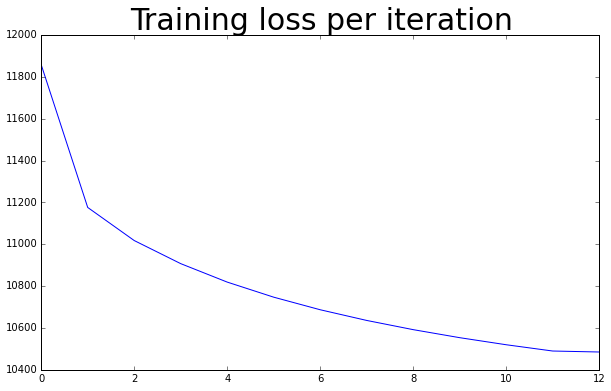

In [68]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(10,6))
plt.title('Training loss per iteration',fontsize=30)
plt.plot(range(len(C.losses)),C.losses)
plt.show()